In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")


X_train = pd.read_csv('./8/X_train.csv.gz', compression='gzip')
X_test = pd.read_csv('./8/X_test.csv.gz', compression='gzip')
y_train = pd.read_csv('./8/y_train.csv.gz', compression='gzip')

# 1a. Wymiary i typy danych
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

# Brakujące wartości
print(f"Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"Missing values in y_train: {y_train.isnull().sum().sum()}")

X_train.info()
X_test.info()
y_train.info()

X_train shape: (3794, 9000)
X_test shape: (670, 9000)
y_train shape: (3794, 2)
Missing values in X_train: 0
Missing values in X_test: 0
Missing values in y_train: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Columns: 9000 entries, LINC01409 to AC240274.1
dtypes: float64(9000)
memory usage: 260.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Columns: 9000 entries, LINC01409 to AC240274.1
dtypes: float64(9000)
memory usage: 46.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        3794 non-null   int64  
 1   Expected  3794 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.4 KB


In [2]:
X_train.describe()

,LINC01409,LINC01128,NOC2L,KLHL17,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,...,MT-CO2,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL592183.1,AC240274.1
count,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,...,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000
mean,0.035938,0.026191,0.073703,0.005194,0.024559,0.353750,0.003372,0.014970,0.012002,0.170528,...,3.519193,3.615837,2.688957,0.962978,3.146859,2.001923,0.214539,3.066664,0.041124,0.002928
std,0.178669,0.161715,0.250832,0.072375,0.167632,0.603110,0.070972,0.136647,0.120104,0.364354,...,0.561173,0.558678,0.638268,0.705792,0.600980,0.686791,0.434988,0.651002,0.189779,0.051882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.255474,3.332831,2.434588,0.000000,2.895820,1.682109,0.000000,2.733922,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.533205,3.612177,2.759313,1.062414,3.203560,2.068186,0.000000,3.096350,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.712288,0.000000,0.000000,0.000000,0.000000,...,3.826243,3.911036,3.061379,1.475809,3.489935,2.435107,0.000000,3.457726,0.000000,0.000000
max,1.815739,3.845255,3.488998,1.815739,2.164696,6.257107,3.491985,2.123145,2.307957,2.865495,...,6.762188,7.080327,5.379358,4.858949,5.907301,5.640658,4.080124,6.507632,1.703918,1.398071


In [3]:
X_test.describe()

,LINC01409,LINC01128,NOC2L,KLHL17,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,...,MT-CO2,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL592183.1,AC240274.1
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,...,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,0.041397,0.025525,0.066191,0.004061,0.021789,0.298613,0.004341,0.013392,0.014377,0.149551,...,3.548152,3.653152,2.720547,0.975285,3.155752,1.965907,0.211010,3.095400,0.041305,0.004690
std,0.192931,0.159731,0.235576,0.059110,0.152423,0.564817,0.062222,0.143046,0.141175,0.357433,...,0.511304,0.533146,0.605519,0.697259,0.591103,0.703796,0.412132,0.621916,0.198768,0.071957
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.276456,3.357919,2.484638,0.000000,2.905256,1.647257,0.000000,2.741953,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.552851,3.636935,2.776877,1.084589,3.188938,2.057698,0.000000,3.113778,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.550307,0.000000,0.000000,0.000000,0.000000,...,3.852408,3.942951,3.071684,1.492286,3.496403,2.412269,0.000000,3.475524,0.000000,0.000000
max,1.369463,1.807777,1.426798,1.156807,2.164696,4.321146,1.126264,2.123145,2.307957,2.865495,...,5.462698,5.609571,4.773784,2.872093,5.059352,3.980441,2.252735,5.469403,1.399372,1.398071


In [4]:
y_train.describe()

,Id,Expected
count,3794.000000,3794.000000
mean,1896.500000,1.135867
std,1095.377789,0.775824
min,0.000000,0.000000
25%,948.250000,0.287829
50%,1896.500000,1.396195
75%,2844.750000,1.780094
max,3793.000000,2.627595


In [5]:
if X_train.columns.equals(X_test.columns):
    print("Nazwy kolumn w X_train i X_test są identyczne.")
else:
    print("Nazwy kolumn w X_train i X_test różnią się.")

Nazwy kolumn w X_train i X_test są identyczne.


In [6]:
if 'Id' in X_train.columns:
    print("Kolumna 'Id' jest obecna w X_train")
else:
    print("Kolumna 'Id' nie jest obecna w X_train")

if 'Id' in X_test.columns:
    print("Kolumna 'Id' jest obecna w X_test")
else:
    print("Kolumna 'Id' nie jest obecna w X_test")

if 'Id' in y_train.columns:
    print("Kolumna 'Id' jest obecna w y_train")
else:
    print("Kolumna 'Id' nie jest obecna w y_train")

Kolumna 'Id' nie jest obecna w X_train
Kolumna 'Id' nie jest obecna w X_test
Kolumna 'Id' jest obecna w y_train


In [7]:
check = X_train.columns[(X_train < 0).any()]
if check.empty:
    print("Brak wartości ujemnych w X_train")
else:
    print(f"Wartości ujemne w X_train: {check}")

check = X_test.columns[(X_test < 0).any()]
if check.empty:
    print("Brak wartości ujemnych w X_test")
else:
    print(f"Wartości ujemne w X_test: {check}")

check = y_train.columns[(y_train < 0).any()]
if check.empty:
    print("Brak wartości ujemnych w y_train")
else:
    print(f"Wartości ujemne w y_train: {check}")

Brak wartości ujemnych w X_train
Brak wartości ujemnych w X_test
Brak wartości ujemnych w y_train


## T.1.1a
Dane treningowe (X_train) składają się z 3794 próbek, z których każda zawiera 9000 poziomów ekspresji genów. Dane testowe (X_test) zawierają 670 próbek, z tymi samymi 9000 poziomami ekspresji genów. Dane targetowe (y_train) zawierają wartości Id oraz Expected dla 3794 próbek treningowych, a więc dla każdej próbki z X_train jest jedna wartość y_train. Nazwy kolumn też się zgadzają.

Ponieważ wszystkie kolumny w X_train i X_test są typu float64, a dane nie zawierają brakujących wartości, ani wartości ujemnych, nie jest wymagana konwersja typów ani uzupełnianie brakujących danych. 

Jedynie co to być może warto by dodać kolumnę z wartościami Id do X_train i X_test, aby móc łatwo odnosić się do danych - na chwilę obecną tego nie potrzebujemy.
Równie dobrze moglibyśmy usunąć kolumnę Id z y_train, ale nie ma to większego znaczenia, będzimey podawać `y_train['Expected']`.

In [8]:
# Kolumny wypełnione jedną wartością w X_train and X_test
single_value_columns_X_train = []
for column in X_train.columns:
    if len(X_train[column].unique()) == 1:
        single_value_columns_X_train.append(column)

single_value_columns_X_test = []
for column in X_test.columns:
    if len(X_test[column].unique()) == 1:
        single_value_columns_X_test.append(column)

print(f"Ilość kolumn wypełnionych jedną wartością w X_train: {len(single_value_columns_X_train)}")
print(f"Ilość kolumn wypełnionych jedną wartością w X_test: {len(single_value_columns_X_test)}")
print(f"Kolumny wypełnione jedną wartością w X_train: {single_value_columns_X_train}")
print(f"Kolumny wypełnione jedną wartością w X_test: {single_value_columns_X_test}")

# Sprawdzenie czy kolumny wypełnione jedną wartością są wypełnione zerami
is_all_zero = True
for column in single_value_columns_X_train:
    if X_train[column].unique()[0] != 0:
        is_all_zero = False
        print(f"Kolumna {column} w X_train nie jest wypełniona zerami.")
if(is_all_zero == True):
    print("Wszystkie kolumny wypełnione jedną wartością w X_train są wypełnione zerami.")

is_all_zero = True
for column in single_value_columns_X_test:
    if X_test[column].unique()[0] != 0:
        is_all_zero = False
        print(f"Kolumna {column} w X_test nie jest wypełniona zerami.")
if(is_all_zero == True):
    print("Wszystkie kolumny wypełnione jedną wartością w X_test są wypełnione zerami.")


Ilość kolumn wypełnionych jedną wartością w X_train: 0
Ilość kolumn wypełnionych jedną wartością w X_test: 122
Kolumny wypełnione jedną wartością w X_train: []
Kolumny wypełnione jedną wartością w X_test: ['MDS2', 'SLFNL1-AS1', 'TRIM45', 'TMCO1-AS1', 'RABGAP1L-DT', 'ANGPTL1', 'ZC3H11B', 'AL592148.3', 'EML6', 'AC068193.1', 'AC073263.2', 'PLGLB2', 'AC092652.3', 'AC026202.2', 'LHFPL4', 'ZNF860', 'SLC35G2', 'KCNAB1', 'TPRG1', 'ATP13A4', 'AFAP1', 'CLNK', 'LINC00504', 'BMP3', 'AC114811.2', 'AP002026.1', 'AC099522.2', 'PKD2L2', 'FAM153B', 'AC139795.2', 'FAM153A', 'HULC', 'AL441883.1', 'GPLD1', 'HIST1H3E', 'UNC5CL', 'EYS', 'FAM184A', 'SOGA3', 'SPDYE16', 'GAL3ST4', 'CNTNAP2', 'WDR86', 'AF131215.4', 'PSD3', 'CA3-AS1', 'AC108925.1', 'FBXO10', 'FAM27C', 'ZNF883', 'AL359644.1', 'MIR600HG', 'AL512770.1', 'CACNB2', 'C10orf25', 'BMPR1A', 'TNKS2-AS1', 'PSD', 'TPH1', 'DEPDC7', 'AP001462.1', 'AP001107.9', 'ARHGAP42', 'LPAR5', 'AC022364.1', 'BEST3', 'USP44', 'LINC02453', 'C12orf42', 'AC007541.1', 'AL35469

In [9]:
# Wypisujemy unikalne wartości na X_train dla kolumn wypełnionych jedną wartością na X_test
for column in single_value_columns_X_test:
    # if X_train[column].nunique() < 3: # Zawsze co najmniej 3 unikalne wartości
        print(f"Kolumna {column} w X_train ma {X_train[column].nunique()} unikalnych wartości.")
        print(X_train[column].value_counts())

Kolumna MDS2 w X_train ma 7 unikalnych wartości.
MDS2
0.000000    3788
0.861312       1
1.093747       1
0.742963       1
1.011804       1
1.419312       1
1.456735       1
Name: count, dtype: int64
Kolumna SLFNL1-AS1 w X_train ma 6 unikalnych wartości.
SLFNL1-AS1
0.000000    3789
0.736795       1
0.118293       1
0.214391       1
0.355972       1
1.536113       1
Name: count, dtype: int64
Kolumna TRIM45 w X_train ma 4 unikalnych wartości.
TRIM45
0.000000    3791
0.208143       1
0.791328       1
0.384381       1
Name: count, dtype: int64
Kolumna TMCO1-AS1 w X_train ma 9 unikalnych wartości.
TMCO1-AS1
0.000000    3786
1.380829       1
0.184205       1
1.140963       1
0.707224       1
1.482742       1
0.934331       1
0.908302       1
1.183127       1
Name: count, dtype: int64
Kolumna RABGAP1L-DT w X_train ma 10 unikalnych wartości.
RABGAP1L-DT
0.000000    3785
1.375714       1
0.889407       1
1.293407       1
0.570980       1
0.419674       1
1.242628       1
0.918632       1
0.44154

In [10]:
# Usuwamy kolumny wypełnione jedną wartością (zerami) z X_train i X_test
single_value_columns = single_value_columns_X_train + single_value_columns_X_test
X_train = X_train.drop(single_value_columns, axis=1)
X_test = X_test.drop(single_value_columns, axis=1)

## T.1.1b
Sprawdzamy też kolumny w pełni wypełnione tę samą wartością. Okazało się, że w X_train nie ma takich kolumn, natomiast w X_test jest ich aż 122, w dodatku wypełnione są one wartościami 0. Ponadto wypisująć ilościowe wartości w X_train dla takowych kolumn, widzimy, że w większości i tak mamy tam zera. Usuwamy te kolumny, naszym ostatecznym celem przecież jest wygenerowanie jak najlepszych modeli predykcyjnych do X_test. Jeżeli nasz model by dobrał znaczące wagi dla tych kolumn, to rezultaty na danych testowych mogłyby być przerażająco niskie (w*0=0). Powinno to nam też trochę pomóc w przyspieszeniu obliczeń.

In [11]:
y_train_stats = y_train['Expected'].describe()
print("Podstawowe statystyki zmiennej objaśnianej 'Expected':")
print(y_train_stats)

Podstawowe statystyki zmiennej objaśnianej 'Expected':
count    3794.000000
mean        1.135867
std         0.775824
min         0.000000
25%         0.287829
50%         1.396195
75%         1.780094
max         2.627595
Name: Expected, dtype: float64


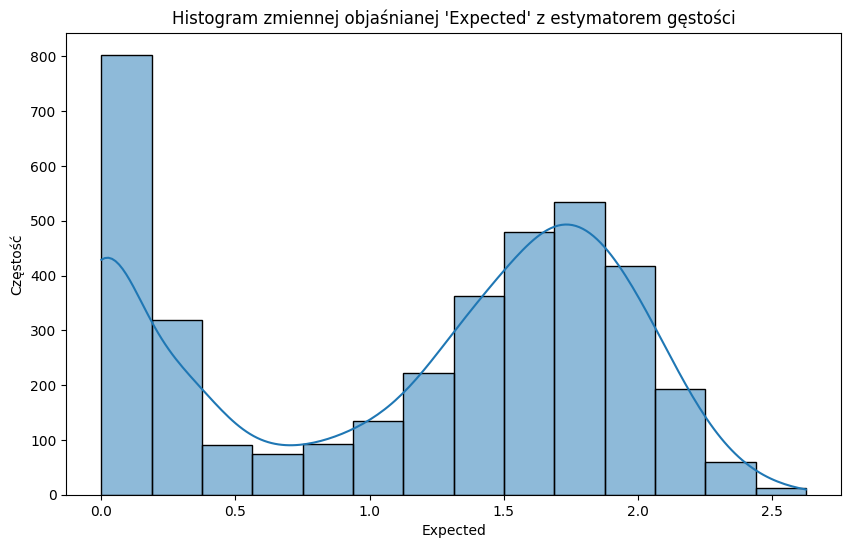

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train['Expected'], kde=True)
plt.title("Histogram zmiennej objaśnianej 'Expected' z estymatorem gęstości")
plt.xlabel('Expected')
plt.ylabel('Częstość')
plt.show()

## T.1.2
Na powyższym histogramie widać rozkład zmiennej Expected wraz z nałożonym wykresem estymatora gęstości (KDE). Rozkład wskazuje, że wartości zmiennej Expected są najbardziej skoncentrowane w dwóch zakresach, z widocznymi pikami w okolicach 0 oraz 1,75.
Co ciekawe, ograniczajęc się do wartości z przedziału [0,7 - 2,7] możemy dostrzec spore podobieństwo do rozkładu Gaussa.

In [13]:
correlations = X_train.corrwith(y_train['Expected'])
# Wybór 250 zmiennych objaśniających najbardziej skorelowanych ze zmienną objaśnianą - wartości bezwzględne
top_250_features = correlations.abs().sort_values(ascending=False).head(250).index

print("250 najbardziej skorelowanych zmiennych objaśniających z wartościami korelacji:")
for feature in top_250_features:
    print(f"{feature}: {correlations[feature]}")

250 najbardziej skorelowanych zmiennych objaśniających z wartościami korelacji:
S100A9: 0.6922059074176635
LYZ: 0.6847961179523823
FCN1: 0.6697284256137741
VCAN: 0.6597798457685634
S100A8: 0.6572760457359673
CTSS: 0.6432416975917321
CST3: 0.6226171802764884
FTH1: 0.6218916193710476
CD14: 0.6111449433466422
IFI30: 0.5920780607757421
S100A6: 0.5818796771738162
MNDA: 0.5780837800936683
TYMP: 0.5731844840170203
AIF1: 0.5676843420982158
GRN: 0.5516162475902603
NEAT1: 0.547887959969962
IL32: -0.5464670716991901
NAMPT: 0.5426152948774091
S100A12: 0.5410169300387302
TSPO: 0.515140277095827
LST1: 0.513035549551491
NKG7: -0.5015493842397647
APLP2: 0.5015114607007046
SAT1: 0.4920346310122309
AC020916.1: 0.4815675150326198
FOS: 0.48078711781888683
S100A4: 0.47966865154222194
CCL5: -0.4787022470229541
CD36: 0.4774494812832836
PLAUR: 0.4761797202324162
CST7: -0.4753731185099187
CEBPD: 0.47068624987415464
GNLY: -0.4701407410168593
AC020656.1: 0.4620413914185645
GZMA: -0.4616659565119718
LGALS1: 0.460

In [14]:
print("Korelacja zmiennych objaśniających ze zmienną objaśnianą (wartości bezwzględne):")
print(f"Abs Korelacji >= 0.3 ma: {sum(correlations.abs() >= 0.3) } zmiennych")
print(f"Abs Korelacji >= 0.4 ma: {sum(correlations.abs() >= 0.4) } zmiennych")
print(f"Abs Korelacji >= 0.5 ma: {sum(correlations.abs() >= 0.5) } zmiennych")
print(f"Abs Korelacj >= 0.6 ma: {sum(correlations.abs() >= 0.6) } zmiennych")

Korelacja zmiennych objaśniających ze zmienną objaśnianą (wartości bezwzględne):
Abs Korelacji >= 0.3 ma: 171 zmiennych
Abs Korelacji >= 0.4 ma: 66 zmiennych
Abs Korelacji >= 0.5 ma: 23 zmiennych
Abs Korelacj >= 0.6 ma: 9 zmiennych


### T.1.3a
Nie wyświetlamy mapy ciepła korelacji między wszytskimi zmiennymi, ponieważ jest ich zbyt dużo. Kompiluje się długo i jest nieczytelne.

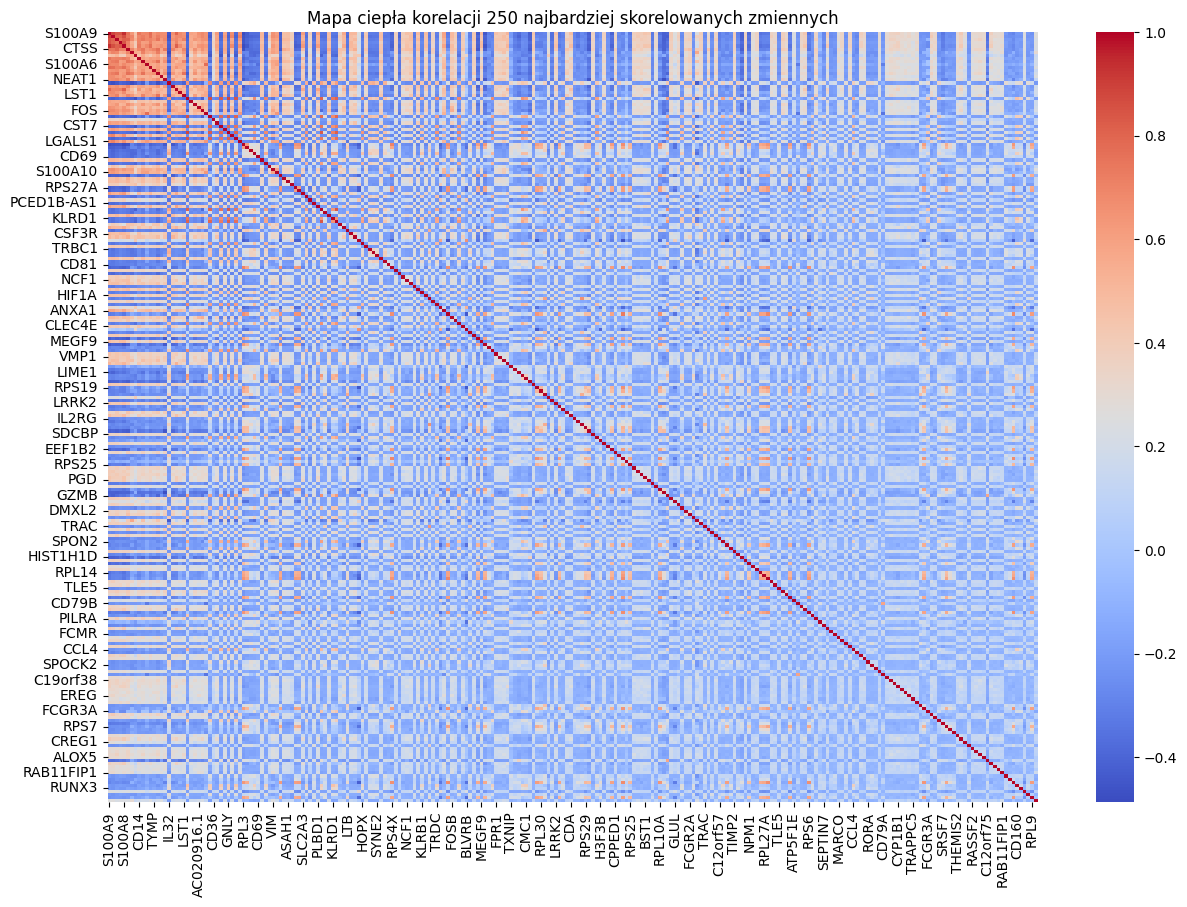

In [15]:
# Wyświetlenie mapy ciepła dla 250 najbardziej skorelowanych zmiennych
plt.figure(figsize=(15, 10))
sns.heatmap(X_train[top_250_features].corr(), cmap='coolwarm')
plt.title('Mapa ciepła korelacji 250 najbardziej skorelowanych zmiennych')
plt.show()

## T.1.3b
Widzimy, że niektóre zmienne mają wysokie korelacje ze zmienną Expected. 9 zmiennych ma powyżej 0,6, natomiast 66 powyżej 0,4.
Wartości korleacji są zarówno dodatnie, jak i ujemne.
Patrząc już na korelacje między parami zmeinnych największe zależności widzimy dla tych zmiennych, które mają największe wartości korelacji z Expected. Mamy posortowane i w oczy się rzuca lewy górny róg. Oczywiście występują też zależności między innymi zmiennymi na poziemie np 0.5. W każdym razie, prawy górny róg bardziej przyciąga uwagę.

## T.2.1
#### Opis modelu ElasticNet

ElasticNet to algorytm regresji liniowej, który łączy kary L1 (regularyzacja Lasso) i L2 (regularyzacja Ridge) w celu poprawy wydajności modelu, szczególnie gdy mamy do czynienia z wysoką korelacją między zmiennymi objaśniającymi lub gdy liczba zmiennych jest większa niż liczba próbek.

#### Optymalizowana funkcja

ElasticNet optymalizuje następującą funkcję kosztu:

$$
L(\beta) = \frac{1}{2n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda_1 \sum_{j=1}^{p} |\beta_j| + \lambda_2 \sum_{j=1}^{p} \beta_j^2
$$

Gdzie:
- $ y_i $ to rzeczywista wartość zmiennej objaśnianej.
- $ \hat{y}_i $ to przewidywana wartość zmiennej objaśnianej przez model.
- $ \beta_j $ to współczynniki regresji.
- $ \lambda_1 $ i $ \lambda_2 $ to parametry regularyzacji, odpowiednio dla kar L1 i L2.

#### Hiperparametry modelu ElasticNet

1. **alpha (λ)**: Parametr regularyzacji kontrolujący siłę całkowitej kary. Wyższa wartość `alpha` prowadzi do większej kary, co może powodować zmniejszenie współczynników regresji.
   
2. **l1_ratio (r)**: Parametr określający proporcję między karami L1 i L2:
   - $ l1\_ratio = 1 $: Model staje się czystym Lasso (kary L1).
   - $ l1\_ratio = 0 $: Model staje się czystym Ridge (kary L2).
   - $ 0 < l1\_ratio < 1 $: Model jest kombinacją Lasso i Ridge.

#### Szczególne przypadki

- **Regresja Grzbietowa (Ridge Regression)**: Otrzymujemy ją, gdy $ l1\_ratio = 0 $, co oznacza, że model używa tylko kar L2.
- **Lasso**: Otrzymujemy ją, gdy $ l1\_ratio = 1 $, co oznacza, że model używa tylko kar L1.


In [16]:
random_state = 43
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
def get_results(model, X_train, y_train):
    train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train['Expected'], train_pred))
    print(f"RMSE (błąd treningowy): {train_rmse}")
    
    # Obliczanie błędów walidacyjnych
    mse_scores = cross_val_score(model, X_train, y_train['Expected'], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-mse_scores)  # Przekształcenie MSE na RMSE
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    
    print(f"Średni błąd walidacyjny (RMSE): {mean_rmse}")
    print(f"Odchylenie standardowe błędu walidacyjnego (RMSE): {std_rmse}")
    return train_rmse, mean_rmse, std_rmse

In [17]:
l1_ratios = [0, 0.22, 1] # 0 dla Ridge, 1 dla Lasso, pośrednie dla kombinacji
alphas = [0.007, 0.015, 0.1]

elastic_net_cv = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=cv, random_state=random_state, n_jobs=-1)
elastic_net_cv.fit(X_train, y_train['Expected'])

ElasticNetCV(alphas=[0.007, 0.015, 0.1],
             cv=KFold(n_splits=5, random_state=43, shuffle=True),
             l1_ratio=[0, 0.22, 1], n_jobs=-1, random_state=43)

In [18]:
print(f"Najlepszy parametr l1_ratio: {elastic_net_cv.l1_ratio_}")
print(f"Najlepszy parametr alpha: {elastic_net_cv.alpha_}")

best_elastic_net = ElasticNet(alpha=elastic_net_cv.alpha_, l1_ratio=elastic_net_cv.l1_ratio_, random_state=random_state)
best_elastic_net.fit(X_train, y_train['Expected'])
train_rmse_en, mean_mse_en, std_mse_en = get_results(best_elastic_net, X_train, y_train)

Najlepszy parametr l1_ratio: 0.22
Najlepszy parametr alpha: 0.015
RMSE (błąd treningowy): 0.30127014899119575
Średni błąd walidacyjny (RMSE): 0.34060641535203956
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.005514921166132959


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Najlepszy parametr l1_ratio scaled: {0.3}")
print(f"Najlepszy parametr alpha scaled: {0.04}")

best_elastic_net_scaled = ElasticNet(alpha=0.04, l1_ratio=0.3, random_state=random_state)
best_elastic_net_scaled.fit(X_train_scaled, y_train['Expected'])
_ = get_results(best_elastic_net_scaled, X_train_scaled, y_train)

Najlepszy parametr l1_ratio scaled: 0.3
Najlepszy parametr alpha scaled: 0.04
RMSE (błąd treningowy): 0.305949373504445
Średni błąd walidacyjny (RMSE): 0.3417970766618816
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.005327117040334705


##### Spróbowałem również wytrenować `ElasticNet` na przeskalowanych danych. Najlepsze wyniki, otrzymałem bardzo podobne, trochę gorsze, a model się nieznacznie dłużej trenował. Dlatego zdecydowałem się na trenowanie modelu na danych oryginalnych.

In [20]:
# param_grid = {
#     'l1_ratio': l1_ratios,  # 0 dla Ridge, 1 dla Lasso, wartości pośrednie dla kombinacji
#     'alpha': alphas,  # Wartości alpha do przetestowania
#     'max_iter': [1000, 3000, 5000],  # Maksymalna liczba iteracji
#     'tol': [0.0001, 0.001, 0.01],  # Tolerancja dla kryterium optymalizacji
#     'selection': ['cyclic', 'random']  # Metoda wybierania cech do aktualizacji
# }

# elastic_net = ElasticNet(random_state=random_state)

# grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train['Expected'])

# best_params = grid_search.best_params_
# print(f"Najlepsze parametry: {best_params}")
# best_elastic_net2 = grid_search.best_estimator_
# train_rmse_en2, mean_mse_en2, std_mse_en2 = get_results(best_elastic_net2, X_train, y_train)

## T.2.2

### Wyjaśnienia

1. **Definiowanie siatki hiperparametrów**: Siatka wartości dla `l1_ratio` i `alpha` jest określona w celu przeszukania przestrzeni hiperparametrów, tu się nie ograniczamy tylko do 3x3 kombinacji, mamy komputer i nie boimy się go używać by uzysakać jak najlepsze wyniki.
2. **Tworzenie modelu ElasticNet z walidacją krzyżową**: Używamy `ElasticNetCV` z walidacją krzyżową (cv=5) do wyboru najlepszych wartości hiperparametrów.

### Wybór liczby podzbiorów (folds) do walidacji krzyżowej

Zdecydowałem się na użycie 5-fold cross-validation. Poniżej przedstawiam uzasadnienie tego wyboru:

1. **Rozmiar zbioru danych**:
   - **X_train shape**: (3794, 9000 - 122)
   - **X_test shape**: (670, 9000 - 122)
   - **y_train shape**: (3794, 2)

   Zbiór danych zawiera 3794 próbki w zbiorze treningowym oraz 9000 - 122 cech. Liczba próbek jest umiarkowana, co pozwala na efektywne zastosowanie 5-fold cross-validation. Przy tej liczbie próbek 5-fold cross-validation zapewnia wystarczającą liczbę próbek w każdym foldzie, co pomaga w stabilnym i dokładnym oszacowaniu wydajności modelu.

2. **Wysoka liczba cech**:
   Przy 9000 cechach, model ElasticNet musi przeszukać dużą przestrzeń parametrów. Zastosowanie 5-fold cross-validation pozwala na szybsze obliczenia w porównaniu do np. 10-fold cross-validation, co jest istotne przy dużej liczbie hiperparametrów do przeszukania. Mniejsza liczba podzbiorów (folds) zmniejsza czas obliczeń, co jest korzystne w kontekście dużej liczby cech.

3. **Stabilność wyników**:
   5-fold cross-validation jest wystarczająco stabilne dla tego rozmiaru zbioru danych. Większa liczba podzbiorów, taka jak 10-fold, mogłaby nieznacznie poprawić dokładność oszacowania błędu, ale zwiększyłaby również koszty obliczeniowe. 5-fold cross-validation zapewnia dobry kompromis między dokładnością oszacowania a efektywnością obliczeniową.

4. **Praktyczne rozważania**:
   5-fold cross-validation jest powszechnie stosowane w praktyce, ponieważ zapewnia dobrą równowagę między dokładnością oszacowań a kosztami obliczeń. Jest to standardowa metoda, która jest dobrze rozumiana i akceptowana w społeczności naukowej.

4. **Podobieństwo do X_test**:
   Też ważne że 3794/5=758 co jest zblizone do rozmiaru X_test (670) co pozwala na dobre oszacowanie wyników na danych testowych.

### Dodatkowe uwagi:
Mammy też (obecnie zakomentowany kod, który używał grid searcha) z dodatkowymi parametrami:
   - **max_iter** - maksymalna liczba iteracji dla optymalizacji.
   - **tol** - kryterium zbieżności.
   - **selection** - metoda wyboru podczas optymalizacji (cykliczna lub losowa). 
  
Oraz wybór miary do oceny modelu:
   - **scoring** - metryka do oceny modelu `neg_mean_squared_error`, bezpośrednio powiązany z optymalizowanym RMSE.
  
Kod ten jednak długo się trenował i często pluł ConvergenceWarning, jego wyniki natomiast były takie jak dla ElasticNetCV, więc zdecydowałem się na samo ElasticNetCV i optymalizację tylko dla `l1_ratio` i `alpha`.

In [21]:
param_grid = {
    'n_estimators': [200, 500],  # Liczba drzew w lesie
    'max_depth': [10, 16],  # Maksymalna głębokość drzewa
    'max_features': ['log2', 0.25]  # Liczba cech do rozważenia przy podziale
}

rf = RandomForestRegressor(random_state=random_state)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train['Expected'])

print(f"Najlepsze parametry: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

Najlepsze parametry: {'max_depth': 16, 'max_features': 0.25, 'n_estimators': 500}


In [22]:
train_rmse_rf, mean_mse_rf, std_mse_rf = get_results(best_rf, X_train, y_train)

RMSE (błąd treningowy): 0.16207123908879198
Średni błąd walidacyjny (RMSE): 0.31838861648851113
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.004466730256801957


## 3a
Do siatki hiperparametrów lasu losowego zdecydowałem się na wybór poniższych:

1. **n_estimators** - liczba drzew w lesie.
- Większa liczba drzew zazwyczaj zwiększa dokładność modelu i stabilność wyników, umożliwiając uchwycenie bardziej złożonych wzorców w danych. Możliwy overfitting.

2. **max_depth** - maksymalna głębokość drzewa.
- Głębokość drzewa wpływa na poziom szczegółowości modelu. Kontrolowanie tego parametru pomaga zrównoważyć dokładność modelu i jego zdolność do generalizacji, zapobiegając nadmiernemu dopasowaniu.

3. **max_features** - liczba cech rozważanych przy każdym podziale.
- Kontrolowanie liczby cech używanych przy każdym podziale wpływa na złożoność i czas trenowania modelu. Mniejsze wartości tego parametru mogą przyspieszyć trenowanie i zwiększyć różnorodność drzew w lesie, co może poprawić zdolność modelu do generalizacji i redukcji nadmiernego dopasowania. Bez tego hiperparametru nie byłem w stanie wygenerować wyników, zbyt długo się model trenował.

In [23]:
# Tworzenie i trenowanie modelu referencyjnego
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train['Expected'])

train_rmse_dummy, mean_mse_dummy, std_mse_dummy = get_results(dummy, X_train, y_train)

RMSE (błąd treningowy): 0.7757213553300533
Średni błąd walidacyjny (RMSE): 0.7760664118730518
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.013353866351326822


In [24]:
# Porównanie wyników
results = {
    'Model': ['ElasticNet', 'Random Forest', 'Model referencyjny'],
    'Błąd treningowy': [train_rmse_en, train_rmse_rf, train_rmse_dummy],
    'Średni błąd walidacyjny': [mean_mse_en, mean_mse_rf, mean_mse_dummy],
    'Odchylenie standardowe błędu walidacyjnego': [std_mse_en, std_mse_rf, std_mse_dummy]
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

             Model  Błąd treningowy  Średni błąd walidacyjny  Odchylenie standardowe błędu walidacyjnego
        ElasticNet         0.301270                 0.340606                                    0.005515
     Random Forest         0.162071                 0.318389                                    0.004467
Model referencyjny         0.775721                 0.776066                                    0.013354


## 3b
Na początku zaznaczę, że sporo czasu poświęciłem na znalezienie optymalnych parametrów i ostatecznie w kodzie zostawiłem kilka przykładowych, w tym najlepszą kombinację (kod odpalałem wielokrotnie z różnymi wartościami hiperparametrów).

### Porównanie modeli:

#### Model referencyjny
Model referencyjny, który przypisuje średnią wartość zmiennej objaśnianej, ma najwyższe błędy treningowe i walidacyjne. Jego wysoka zmienność błędów walidacyjnych wskazuje na bardzo słabą zdolność do uchwycenia zależności w danych, co sprawia, że jest to najgorszy z rozważanych modeli.

#### ElasticNet
Model ElasticNet osiąga znacznie lepsze wyniki niż model referencyjny, zarówno pod względem błędu treningowego, jak i walidacyjnego. Niskie odchylenie standardowe błędu walidacyjnego wskazuje na stabilność modelu. Chociaż jego błąd treningowy jest wyższy niż w przypadku Random Forest, różnica między błędami treningowymi a walidacyjnymi jest mniejsza, co sugeruje, że model jest dobrze dopasowany bez znaczącego nadmiernego dopasowania.

#### Random Forest
Model Random Forest ma najniższy błąd treningowy spośród wszystkich modeli, ale różnica między błędem treningowym a walidacyjnym jest znacząca, co wskazuje na nadmierne dopasowanie. Mimo że osiąga najniższy błąd walidacyjny, jego znacznie niższy błąd treningowy sugeruje, że model może być zbyt złożony i dopasowany do danych treningowych, co może wpłynąć na jego zdolność do generalizacji na nowych danych.

### Wnioski
Pomimo że model Random Forest wykazuje oznaki nadmiernego dopasowania, osiąga najniższy błąd walidacyjny, co sugeruje, że jest najbardziej precyzyjny spośród wszystkich rozważanych modeli. Model ElasticNet, choć bardziej stabilny i mniej podatny na nadmierne dopasowanie, nie osiąga tak niskiego błędu walidacyjnego jak Random Forest. W związku z tym, jeśli zależy nam na maksymalnej precyzji prognoz i jesteśmy w stanie zaakceptować pewne ryzyko nadmiernego dopasowania, `Random Forest` będzie najlepszym wyborem i jeżeli mam wskazać jednego zwycięzcę, to on.

In [25]:
# param_grid = {
#     # 'hidden_layer_sizes': [(100, 50), (200, 100), (100, 200, 100)],  # Architektura warstw ukrytych
#     # 'hidden_layer_sizes': [(800, 800), (1200, 1200)],  # Architektura warstw ukrytych
#     # 'hidden_layer_sizes': [(2000, 800, 300, 60, 1)],  # Architektura warstw ukrytych
#     'hidden_layer_sizes': [(1000, 600, 1)],  # Architektura warstw ukrytych
#     'activation': ['relu'],  # Funkcja aktywacji
#     'solver': ['adam'],  # Algorytm optymalizacyjny
#     'alpha': [0.01],
#     # 'alpha': [0.01, 0.05, 0.1, 0.3],  # Współczynnik regularizacji L2
#     'learning_rate': ['invscaling', 'adaptive'],  # Harmonogram nauki
#     'max_iter': [1000],  # Maksymalna liczba iteracji
#     'early_stopping': [True]
# }
# mlp = MLPRegressor(random_state=random_state)
# grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train['Expected'])

# print(f"Najlepsze parametry: {grid_search.best_params_}")
# best_mlp = grid_search.best_estimator_


## 4a
Zdecydowałem się również na trenowanie MLP, ponieważ potrafi modelować złożone, nieliniowe zależności w danych, co daje mu przewagę nad prostszymi modelami. Mieliśmy w nim wiele hiperparametrów które dogłębnie przeszukiwałem godzinami. Ponadto dodam, że MLP trenowało się znacznie szybciej niż Random Forest w którym optymalne było n_features w tysiącach.

Trenowałem też MLP, zarówno na danych oryginalnych, jak i przeskalowanych. Znowu wyniki były dość podobne, a czas trenowania danych obrobionych za pomocą StandardScaler był dłuższy, więc zdecydowałem się na dalsze próby trenowania modelu na danych oryginalnych, podobnie jak w przypadku ElasticNet.

In [74]:
hidden_layers = (200, 200, 200, 200, 200, 200, 10)
alpha = 0.0045

print(f"hidden_layers: {hidden_layers}")
print(f"alpha: {alpha}")
best_mlp = MLPRegressor(hidden_layer_sizes=hidden_layers, activation='relu', solver='adam', alpha=alpha, 
                             learning_rate='adaptive', max_iter=1000, early_stopping=True, random_state=random_state)
best_mlp.fit(X_train, y_train['Expected'])
_ = get_results(best_mlp, X_train, y_train)

hidden_layers: (200, 200, 200, 200, 200, 200, 10)
alpha: 0.0045
RMSE (błąd treningowy): 0.228102901585586
Średni błąd walidacyjny (RMSE): 0.32581487827642513
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.0037768775646680503


In [27]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, ReLU, Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from scikeras.wrappers import KerasRegressor

# def build_model():
#     alpha = 0.13
#     l2 = 0.00001
#     layer_sizes = (400, 250, 200)
#     print(f"Model: {layer_sizes}, alpha: {alpha}, l2: {l2}")
#     model = Sequential()
#     model.add(Input(shape=(X_train.shape[1],)))
#     for size in layer_sizes:
#         model.add(Dense(size, activation='relu'))
#         # model.add(Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2)))
#         model.add(Dropout(alpha))
#     model.add(Dense(1))
#     model.add(ReLU())
#     model.compile(optimizer=Adam(learning_rate=0.00005), loss='mean_squared_error')
#     return model

# keras_regressor = KerasRegressor(model=build_model, epochs=1000, batch_size=64, verbose=1, 
#                         callbacks=[EarlyStopping(patience=5), 
#                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)], validation_split=0.2)

# keras_regressor.fit(X_train, y_train['Expected'])

# _ = get_results(keras_regressor, X_train, y_train)
# # train_pred = keras_regressor.predict(X_train)
# # train_rmse = np.sqrt(mean_squared_error(y_train['Expected'], train_pred))
# # print(f"RMSE (błąd treningowy): {train_rmse}")

## 4b
Trenowałem modela na przeróżne sposoby. Grid zapuszczony na wiele godzin jak i reczne dopasowywanie argumentów. Cięzko było trafić w dobrą kombinację parametrów. Zostawiam zakomentowany kod, żeby nie było, że leję wodę. Zostawiam te najlepsze fragmenty.

In [59]:
class CombinedModel(BaseEstimator, RegressorMixin):
    def __init__(self, models, return_type):
        self.models = models
        self.return_type = return_type
    
    def fit(self, X, y):
        self.models_ = [clone(model) for model in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        if self.return_type == 'mean':
            return np.maximum(0, np.mean(predictions, axis=1))
        elif self.return_type == 'median':
            return np.maximum(0, np.median(predictions, axis=1))
        elif self.return_type == 'weighted':
            sorted_predictions = np.sort(predictions, axis=1)
            weights = np.array([1, 2, 1])  # wagi dla najmniejszej, środkowej i największej wartości
            weighted_avg = np.average(sorted_predictions, axis=1, weights=weights)
            return np.maximum(0, weighted_avg)

In [55]:
combined_model_mean = CombinedModel(models=[best_elastic_net, best_rf, best_mlp], return_type='mean')
combined_model_mean.fit(X_train, y_train['Expected'])
_ = get_results(combined_model_mean, X_train, y_train)

RMSE (błąd treningowy): 0.2166233894806213
Średni błąd walidacyjny (RMSE): 0.31626964522799816
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.004178364046078923


In [56]:
combined_model_median = CombinedModel(models=[best_elastic_net, best_rf, best_mlp], return_type='median')
combined_model_median.fit(X_train, y_train['Expected'])
_ = get_results(combined_model_median, X_train, y_train)

RMSE (błąd treningowy): 0.2128393649336396
Średni błąd walidacyjny (RMSE): 0.3165212826435819
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.005061897188047653


In [60]:
combined_model_weighted = CombinedModel(models=[best_elastic_net, best_rf, best_mlp], return_type='weighted')
combined_model_weighted.fit(X_train, y_train['Expected'])
_ = get_results(combined_model_weighted, X_train, y_train)

RMSE (błąd treningowy): 0.21498766442547157
Średni błąd walidacyjny (RMSE): 0.31591814956502623
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.004347286632909445


In [61]:
model_3combined = combined_model_weighted

y_pred = model_3combined.predict(X_test)
predictions = pd.DataFrame({
    'Id': X_test.index,
    'Expected': y_pred
})
predictions.to_csv('439954_predykcja.csv', index=False)
print("Predykcje zapisane do pliku: '439954_predykcja.csv'.")

_ = get_results(model_3combined, X_train, y_train)

Predykcje zapisane do pliku: '439954_predykcja.csv'.
RMSE (błąd treningowy): 0.21498766442547157
Średni błąd walidacyjny (RMSE): 0.31591814956502623
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.004347286632909445


In [62]:
model_3combined

CombinedModel(models=[ElasticNet(alpha=0.015, l1_ratio=0.22, random_state=43),
                      RandomForestRegressor(max_depth=16, max_features=0.25,
                                            n_estimators=500, random_state=43),
                      MLPRegressor(alpha=0.0045, early_stopping=True,
                                   hidden_layer_sizes=(200, 200, 200, 200, 200,
                                                       200, 10),
                                   learning_rate='adaptive', max_iter=1000,
                                   random_state=43)],
              return_type='weighted')

## 4c
Szczerze mówiąc spędziłem kilkaset godzin na szukaniu odpowiednich parametrów dla każdego z modeli. W kodzie widnieją kombinacje zawierające te najlepsze. Proces robiłem iteracyjnie uzywając głównie Grid Searcha i Random Searcha, ostatecznie samemu dobierając coraz to lepsze wartości.  

Niektóre modele były bardziej obiecujące, ale jest w nich czynnik ryzyka nadmiernego dopasowania. Jako priorytet postawiłem bezbieczeństwo. Prawdopodonie już mój `ElasticNet` przebije tego wytrenowanego przez prowadzących. A przynajmniej mam taką nadzieję, że konkurencyjny model był robiony łaskawie w stosunku do studentów.

Aby postarać się uniknąć przykrej sytuacji przy ocenie moim ostatecznym modelem będzie kombinacja 3 najlepiej wytrenowanych modeli.
W tym podejściu liczę że odchylenia są równomiernie rozłożone, zarówno w górę jak i w dół. 
Aby z kolei za bardzo już nie komplikować nasz potężny model, który myślę że okaże się oryginalnym pomysłem klonuje i trenuje każdy z modeli.
Jako ostateczną predykcję próbowałem zarówno medianę jak i średnią, ujemne wartości zastępując zerem (nie ma ich w danych jak pokazaliśmy w podpunkcie 1). Oba podejścia mają wady i zalety:
- Mediana jest bardziej odporna na outliery, w niej idealnie gdyby modele odchylone były w różne strony. Jeżeli każdy przewidziałby zbyt nisko bądź zbyt wysoko, to niestety predykcja nie będzie idealnym wyborem z tych trzech. Natomiast całkiem dobrze nas zabezpiecza przed podaniem wartości z kosmosu.
- Średnia z kolei pozwala na większy wpływ każdego modelu na ostateczny wynik. Przebija naszą medianę w sytuacji gdy średnia skrajnych wartości jest bliżej targetu niż środkowa wartość sama w sobie. Nie będziemy się też tu dużo rozwodzić.

Wytrenowałem zarówno model co brał medianę jak i model co brał średnią.
Na przeprowadzonej przez nas cross walidacji wyniki były bardzo zbliżone. Model biorący średnią trochę gorzej wypadł na danych treningowych, co nas cieszy bo wystąpił tam mniejszy overfitting. Ponadto jego błąd walidacyjny był nieznacznie mniejszy. Co ważne odchylenie standardowe błedu walidacyjnego było mniejsze w przypadku modelu biorącego średnią, co sugeruje że większą stabilność.

Dalej jeszce nie byłem w pełni przekonany i bałem się jednak losowego wystrzelenia spowodowanego choć jedną bardzo odchyloną predykcją.
Żeby to zamortyzować wymysliłem model oparty na średniej ważonej. Najmniejsza i najwiękasza przewidywana wartość dostają wagi 1, natomiast mediana ma wagę 2. W ten sposób trochę zabezpieczam się przed kompletnie oderwaną predykcją.

Model ten osiągnął najlepszy wynik na cross walidacji, mimo niewiele większego standardowego odchylenia tego błędu w porównaniu z modelem mean. Błąd treningowy wciąż na szczęście większy niż model median. Powyższe i świadomość większego bezpieczeństwa przekonały mnie do niego.

Ostatecznie wszytskie modele `CombinedModel` przebiły zarówno `ElasticNet`, `RandomForest` i `MLP` na cross walidacji.

In [78]:
combined_model_mlp_rf = CombinedModel(models=[best_mlp, best_rf], return_type='mean')
combined_model_mlp_rf.fit(X_train, y_train['Expected'])
_ = get_results(combined_model_mlp_rf , X_train, y_train)

RMSE (błąd treningowy): 0.18579634109307785
Średni błąd walidacyjny (RMSE): 0.3140181150841035
Odchylenie standardowe błędu walidacyjnego (RMSE): 0.004213355993777512


In [79]:
final_model = combined_model_mlp_rf 
y_pred = final_model.predict(X_test)
predictions = pd.DataFrame({
    'Id': X_test.index,
    'Expected': y_pred
})
predictions.to_csv('439954_predykcja.csv', index=False)
print("Predykcje zapisane do pliku: '439954_predykcja.csv'.")

Predykcje zapisane do pliku: '439954_predykcja.csv'.


In [80]:
final_model

CombinedModel(models=[MLPRegressor(alpha=0.0045, early_stopping=True,
                                   hidden_layer_sizes=(200, 200, 200, 200, 200,
                                                       200, 10),
                                   learning_rate='adaptive', max_iter=1000,
                                   random_state=43),
                      RandomForestRegressor(max_depth=16, max_features=0.25,
                                            n_estimators=500,
                                            random_state=43)],
              return_type='mean')

## 4d
Dalej jescze pomyślałem, że możemy spróbować odważniej i nie brać `ElasticNet` pod uwagę. W ten sposób biorąc samo mlp jak i random forest stworzyłem kolejny combined model, po prostu biorący średnią. W końcowych wynikać nie ma 0.0.
Przebił wszytskie pozostałe modele na cross walidacji.
Overfitting też w normie.
 

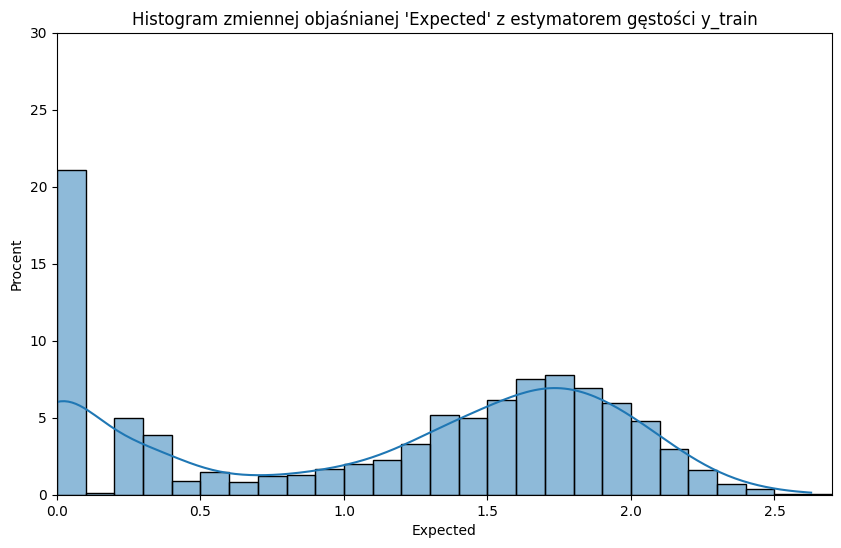

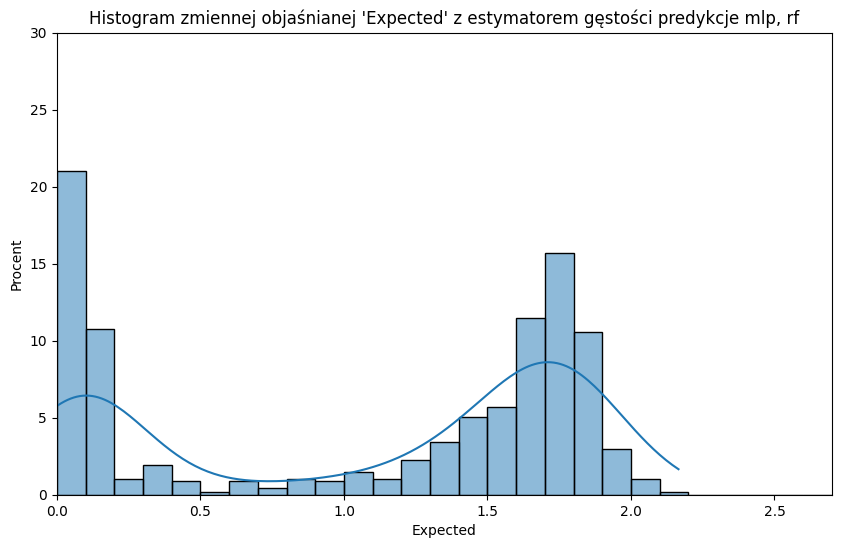

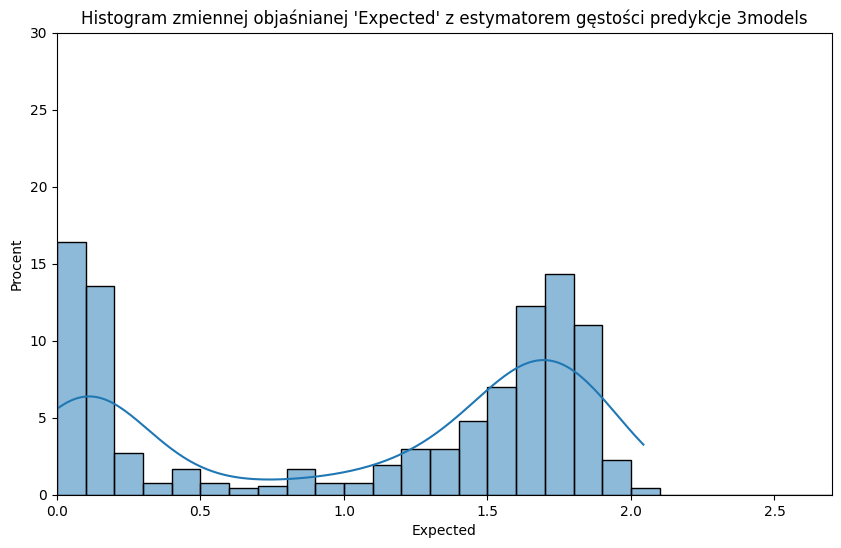

In [23]:
def plot_histogram(data, title):
    bins = np.arange(0, 2.8, 0.1)
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Expected'], bins=bins, kde=True, stat='percent')
    plt.title(title)
    plt.xlabel('Expected')
    plt.ylabel('Procent')
    plt.xlim(0, 2.7)
    plt.ylim(0, 30)
    plt.show()

y_pred_mlp_rf = pd.read_csv('439954_predykcja.csv')
y_pred_3models = pd.read_csv('439954_predykcja_3models.csv')

plot_histogram(y_train, "Histogram zmiennej objaśnianej 'Expected' z estymatorem gęstości y_train")
plot_histogram(y_pred_mlp_rf, "Histogram zmiennej objaśnianej 'Expected' z estymatorem gęstości predykcje mlp, rf")
plot_histogram(y_pred_3models, "Histogram zmiennej objaśnianej 'Expected' z estymatorem gęstości predykcje 3models")


## 4e
Porównałem też histogramy i bardziej pod względem wyglądu `y_train` faktycznie wyglądał model ze śrenią mlp i rf.
Generowałem histogramy dla predykcji `X_test` (ręcznie nazwę pliku zmieniłem).

Zakładając statystyczną niezależność rozkłady treningowe i testowe powinny być podobne. 
Szczególną uwagę zwróciłem na okolice 0-0.1, jak i 1.7-1.8.

Jako najlepszy ze swoich modeli wybieram `CombinedModel` biorący średnią z najlepszych `RandomForest` i `MLP`.

Mam nadzieję, że wyniki na danych testowych będą zadowalające.
Jak i że ogromny wysiłek włożony w ten projekt zostanie doceniony.